# Feature testbed

This notebook is meant to serve as a testbed for exploring new visual information techniques that may derive in better features

### ORB (Oriented FAST and Rotated BRIEF)

ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features. But one problem is that, FAST doesn’t compute the orientation. So what about rotation invariance? Authors came up with following modification.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with x and y which should be in a circular region of radius r, where r is the size of the patch.

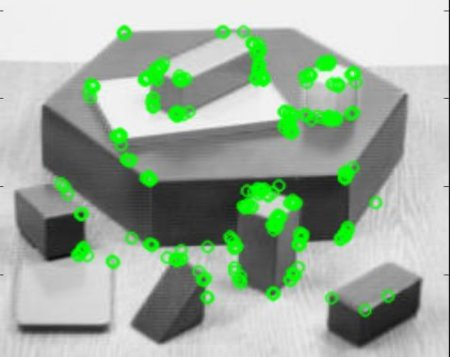

In [ ]:
import numpy as np
import cv2
  
ESC=27   
cap = cv2.VideoCapture('../../data/1080p_watermark/5GIahTMrZuc.mp4')
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
lower = 100
upper = 200
_,prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_frame = cv2.resize(prev_frame, (480, 270), interpolation=cv2.INTER_LINEAR)
prev_frame = cv2.Canny(prev_frame, lower, upper)


firsttime=True
j=0
while True:
   
    ret, frame = cap.read()
    if ret:
        j += 1
       
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (480, 270), interpolation=cv2.INTER_LINEAR)
        # Compute the Canny edges for the reference frame, its next frame and the next frame of the rendition
        frame = cv2.Canny(frame, lower, upper)
        
        kpTrain = orb.detect(prev_frame,None)
        kpTrain, desTrain = orb.compute(prev_frame, kpTrain)
        #frame = frame - prev_frame
        kpCam = orb.detect(frame,None)
        kpCam, desCam = orb.compute(frame, kpCam)
        
        matches = bf.match(desCam,desTrain)
        dist = [m.distance for m in matches]
        thres_dist = (sum(dist) / len(dist)) * 0.2
        matches = [m for m in matches if m.distance < thres_dist]   

                
        if firsttime==True:
            h1, w1 = frame.shape[:2]
            h2, w2 = frame.shape[:2]
            nWidth = w1+w2
            nHeight = max(h1, h2)
            hdif = int((h1-h2)/2)
            firsttime=False

        result = np.zeros((nHeight, nWidth), np.uint8)
        result[hdif:hdif+h2, :w2] = prev_frame
        result[:h1, w2:w1+w2] = frame
        print('Frame: {} Matches: {}'.format(j, len(matches)))
        for i in range(len(matches)):
            pt_a=(int(kpTrain[matches[i].trainIdx].pt[0]), int(kpTrain[matches[i].trainIdx].pt[1]+hdif))
            pt_b=(int(kpCam[matches[i].queryIdx].pt[0]+w2), int(kpCam[matches[i].queryIdx].pt[1]))
            cv2.circle(result, pt_a, 15, (255,0,0))
            cv2.circle(result, pt_b, 15, (255,0,0))
            cv2.line(result, pt_a, pt_b, (i, 0, 0))

        cv2.imshow('Video', result)
        prev_frame = frame
    else:
        break
    key = cv2.waitKey(10)                                 
    if key == ESC:
        break

cv2.destroyAllWindows()
cap.release()

### Saliency

In essence, saliency is what “stands out” in a photo or scene, enabling your eye-brain connection to quickly (and essentially unconsciously) focus on the most important regions.

About the saliency, there is a rich literature but the development is very fragmented. The principal purpose of OpenCV's API is to give a unique interface, a unique framework for use and plug sever saliency algorithms, also with very different nature and methodology, but they share the same purpose, organizing algorithms into three main categories:

**Static Saliency**: algorithms belonging to this category, exploit different image features that allow to detect salient objects in a non dynamic scenarios.

**Motion Saliency**: algorithms belonging to this category, are particularly focused to detect salient objects over time (hence also over frame), then there is a temporal component sealing cosider that allows to detect "moving" objects as salient, meaning therefore also the more general sense of detection the changes in the scene.

**Objectness**: Objectness is usually represented as a value which reflects how likely an image window covers an object of any category. Algorithms belonging to this category, avoid making decisions early on, by proposing a small number of category-independent proposals, that are expected to cover all objects in an image. Being able to perceive objects before identifying them is closely related to bottom up visual attention (saliency).

In [ ]:
import numpy as np
import cv2


saliency = cv2.saliency.StaticSaliencySpectralResidual_create()

ESC=27   
cap = cv2.VideoCapture('../../data/1080p/MccVw7XeKlc.mp4')
cap_rend = cv2.VideoCapture('../../data/144p/MccVw7XeKlc.mp4')
_,prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_frame = cv2.resize(prev_frame, (480, 270), interpolation=cv2.INTER_LINEAR)


firsttime=True
j=0
while True:
   
    ret, frame = cap.read()
    ret_rend, rend_frame = cap_rend.read()
    if ret and ret_rend:
        j += 1
       
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (480, 270), interpolation=cv2.INTER_LINEAR)
        
        rend_frame = cv2.cvtColor(rend_frame, cv2.COLOR_BGR2GRAY)
        rend_frame = cv2.resize(rend_frame, (480, 270), interpolation=cv2.INTER_LINEAR)
        # Compute the Canny edges for the reference frame, its next frame and the next frame of the rendition
        
       
        (success, saliencyMap_rend) = saliency.computeSaliency(rend_frame)
        saliencyMap_rend = (saliencyMap_rend * 255).astype("uint8")
        saliencyMap_rend = cv2.threshold(saliencyMap_rend.astype("uint8"), 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        
        (success, saliencyMap) = saliency.computeSaliency(frame)
        saliencyMap = (saliencyMap * 255).astype("uint8")
        saliencyMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        
        if firsttime==True:
            h1, w1 = frame.shape[:2]
            h2, w2 = frame.shape[:2]
            nWidth = w1+w2
            nHeight = max(h1, h2)
            hdif = int((h1-h2)/2)
            firsttime=False

        result = np.zeros((nHeight, nWidth), np.uint8)
        result[hdif:hdif+h2, :w2] = saliencyMap
        result[:h1, w2:w1+w2] = saliencyMap_rend
        
        cv2.imshow('Video', result)
        diff = saliencyMap - saliencyMap_rend
        diff = cv2.threshold(diff.astype("uint8"), 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        
        cv2.imshow('Diff', diff )
        
    else:
        break
    key = cv2.waitKey(10)                                 
    if key == ESC:
        break

cv2.destroyAllWindows()
cap.release()